In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun
from IPython.display import Image
import cdo

In [2]:
from scipy.spatial import KDTree

The goal of the code is to efficiently find cities previously defined on a global 13 km grid using a "nearest neighbor" approach on a 40 km grid. This code is exemplary on one output hour, but can be easily transferred to bigger datasets. 


Further reading: https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b


In [3]:
#load the dataset

ds_ens = xr.open_dataset(f'./ensemble_members_data/mem001/fc_DOM01_0120_mem001_NU_grid.nc')
ds_det = xr.open_dataset(f'./data_all/fc_DOM01_0001_NU_urban_grid.nc')

In [145]:
ds_ens2 = xr.open_dataset('fc_DOM01_0002_mem001_NU_urban_grid.nc')
ds_ens3 = xr.open_dataset('fc_DOM01_0003_mem001_NU_urban_grid.nc')

In [121]:
#define the k-d tree

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('fc_DOM01_0120_mem001_NU_grid.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.clat.values.flatten(),
                                         self.model_ds.clon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [122]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [124]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [126]:
ds_ens_cities = ds_ens.isel(cell=indices_cities_ens)

/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


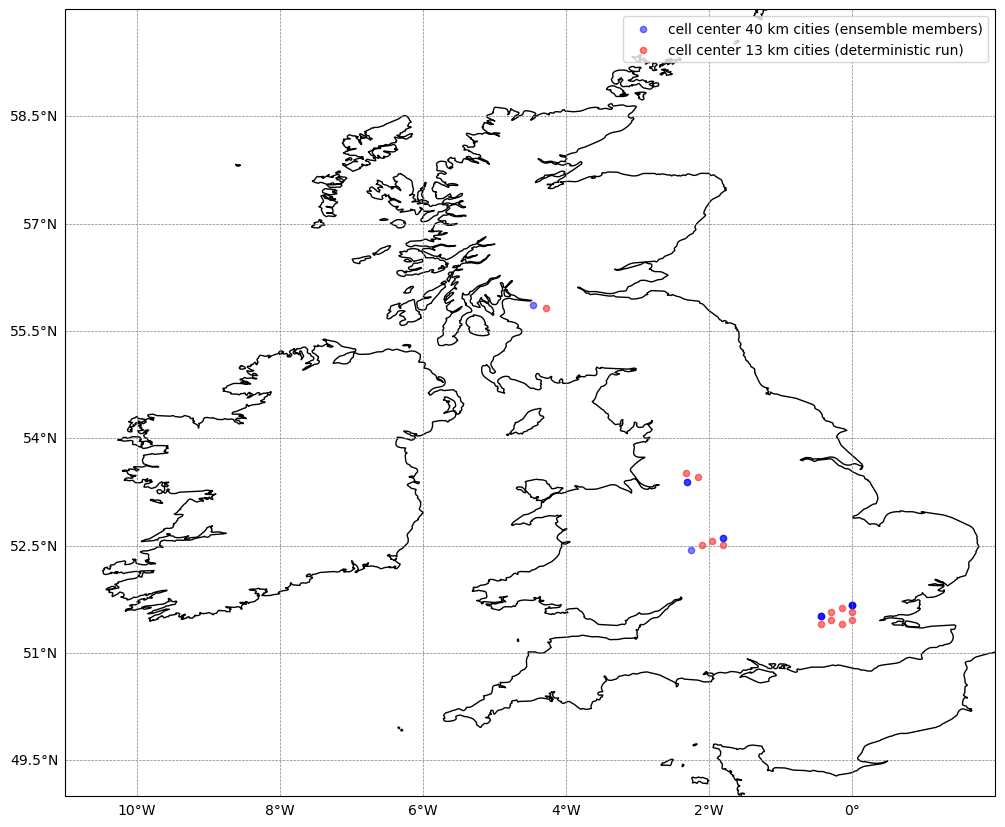

In [156]:
#check visually if it worked :)

cx = np.degrees(np.asarray(ds_ens2["clon"]))
cy = np.degrees(np.asarray(ds_ens2["clat"]))

cx_det = np.degrees(np.asarray(ds_det["clon"]))
cy_det = np.degrees(np.asarray(ds_det["clat"]))

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(cx, cy, s=20, c='blue', alpha=0.5, transform=ccrs.PlateCarree(), label = 'cell center 40 km cities (ensemble members)')
ax.scatter(cx_det, cy_det, s=20, c='red', alpha=0.5, transform=ccrs.PlateCarree(), label ='cell center 13 km cities (deterministic run)')
ax.coastlines()
ax.set_extent([-11, 2, 49, 60], crs=ccrs.PlateCarree())
ax.legend()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False

plt.savefig('./plots/vgl_ens_det.jpeg', dpi=300)